In [81]:
#Copyright (c) 2019 Primoz Ravbar UCSB Licensed under BSD 2-Clause [see LICENSE for details] Written by Primoz Ravbar

import tensorflow.keras as K

import numpy as np
import scipy
from scipy import ndimage
from scipy import misc
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.colors as mcolors
import natsort
from PIL import Image

import skimage
from skimage import transform

from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.models import Model


In [82]:
labelFolder = 'C:\\Users\\ravbar\\Desktop\\ABRS_Python_GHws1\\PR2'

fileList = natsort.natsorted(os.listdir(labelFolder),reverse=False)

STrec = np.zeros((1,80,80,3))
ethoRec = np.zeros((1,1))

for fileName in fileList:
    
    fileDirPathName = labelFolder + '\\' + fileName
    
    if fileName[0] == 'S':
          
        with open(fileDirPathName, "rb") as fl:
            STfile = pickle.load(fl)
        
        STrec = np.concatenate((STrec, STfile), axis = 0)
            
    if fileName[0] == 'e':
        
        with open(fileDirPathName, "rb") as fl:
            etho = pickle.load(fl)        
        
        ethoRec = np.concatenate((ethoRec, etho), axis = 1)


Xin1 = STrec
yVectRec1 = np.transpose(ethoRec+1)

In [83]:
print(np.shape(Xin1))
print(np.shape(yVectRec1))

(17894, 80, 80, 3)
(17894, 1)


In [84]:
import ABRS_behavior_analysis as ba

behProbVect = ba.get_behavior_probability(np.transpose(yVectRec1))

print(behProbVect)

[[4787.]
 [2758.]
 [1820.]
 [1655.]
 [1805.]
 [2802.]
 [ 372.]
 [1207.]
 [ 688.]
 [   0.]]


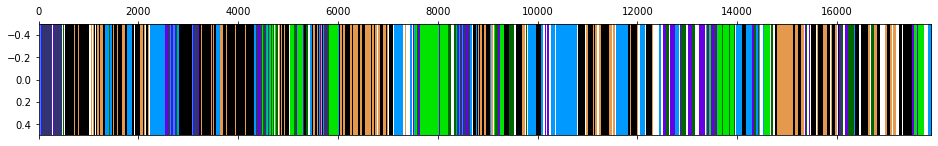

In [85]:
%matplotlib inline
#%matplotlib notebook

from ABRS_data_vis import create_colorMat
from ABRS_data_vis import cmapG
from ABRS_data_vis import cmapAP

plt.matshow(np.transpose(yVectRec1), aspect='auto',cmap=cmapG);plt.show()


In [86]:
# Balance and shuffle the training data and labels

from ABRS_modules import balance_labels2d

y=yVectRec1
y=y[:,0]

XinComb = Xin1/1 #normalize images to 0-1

XShf, lShf = shuffle(XinComb, y, random_state=0)
yShf = np.transpose(lShf)

yShfRs = np.zeros((np.shape(yShf)[0],1))
yShfRs[:,0] = yShf

limitCol = np.zeros((10,1))
limitCol[0]=8000
limitCol[1]=8647
limitCol[2]=8647
limitCol[3]=8647
limitCol[4]=8647
limitCol[5]=8647
limitCol[6]=8647
limitCol[7]=8647
limitCol[8]=8647
#limitCol[9]=8647
#limitCol[7]=0

yShfRsBal,XShfBal = balance_labels2d(yShfRs,XShf,limitCol)

XShfBal, yShfRsBal = shuffle(XShfBal, yShfRsBal, random_state=0)


XTrain = XShfBal[0:int(np.shape(XShfBal)[0]/1),:,:,:] 
yTrain = yShfRsBal[0:int(np.shape(yShfRsBal)[0]/1),0]

In [74]:
print(np.shape(XTrain))
print(np.shape(yTrain))

(17205, 80, 80, 3)
(17205,)


In [87]:
# data augmentation (rotation)

XRotated = np.zeros((np.shape(XTrain)[0],np.shape(XTrain)[1],np.shape(XTrain)[2],np.shape(XTrain)[3]))

for i in range(0,np.shape(XRotated)[0]):
    
    XRotated[i,:,:,:] = transform.rotate(XTrain[i,:,:,:],np.random.randint(360))/1

XAugmented = np.vstack((XTrain,XRotated))
yAugmented = np.hstack((yTrain,yTrain))

XAugmented, yAugmented = shuffle(XAugmented, yAugmented, random_state=0)

In [88]:
print(np.shape(XAugmented))
print(np.shape(yAugmented))

(34410, 80, 80, 3)
(34410,)


In [ ]:
# if you already have a saved model

saved_model = load_model('saved_model_name.h5') #

model_name = 'saved_model_name.h5'

model = saved_model

In [89]:
# build a new model (ResNet50) ONLY RUN THIS IF STARTING A NEW MODEL

model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(80, 80, 3), pooling=None,
)

# freeze the training if you want to use a pre-trained model
#for layer in model.layers:
#	layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)


model = Model(inputs=model.inputs, outputs=output)

model_name = 'My_new_model.h5'

#model.summary()

In [90]:
# HAPPY TRAINING! 

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
mc = ModelCheckpoint(model_name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

model.fit(XAugmented, yAugmented, batch_size=32, epochs=15, validation_split=0.1, callbacks=[es, mc])

Epoch 1/15
293/968 [========>.....................] - ETA: 17:14 - loss: 1.6445 - accuracy: 0.5752

KeyboardInterrupt: 

In [64]:
# get predictions from the training data

predictionsProbComb = model.predict(Xin1/1)

predictionLabelComb = np.zeros((1,np.shape(predictionsProbComb)[0]))
predictionLabelComb[0,:] = np.argmax(predictionsProbComb,axis=1) #this is the ethogram of the training data

In [16]:
# save model if unsaved 

model.save('model_ResNet_new_name.h5')

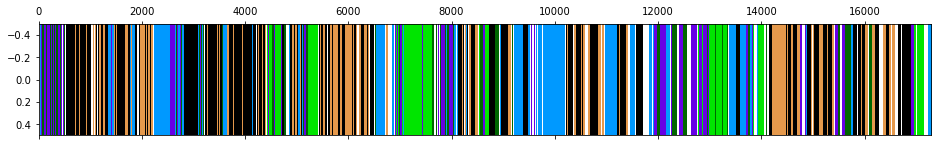

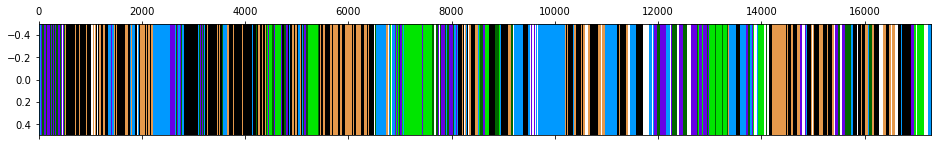

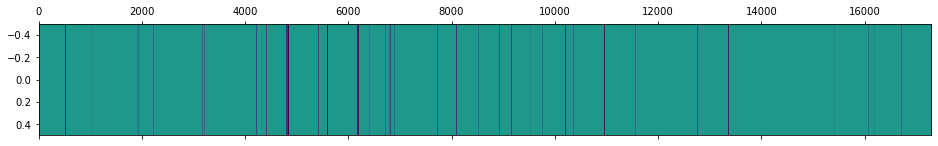

[821.]


In [68]:
 #plot the labels and the predictions (NOTE: the predictions here are from the training data so it 
 # will look better than predictions from the new data)   
    
%matplotlib inline
#%matplotlib notebook

from ABRS_data_vis import create_colorMat
from ABRS_data_vis import cmapG
from ABRS_data_vis import cmapAP

plt.matshow(np.transpose(yVectRec1), aspect='auto',cmap=cmapG);plt.show()
#plt.matshow(np.transpose(yAugmented),interpolation=None, aspect='auto',cmap=cmapG);plt.show()
plt.matshow(predictionLabelComb, aspect='auto',cmap=cmapG);plt.show()

plt.matshow(predictionLabelComb-np.transpose(yVectRec1), aspect='auto');plt.show()

nz = predictionLabelComb-np.transpose(yVectRec1)
nz[nz<0] = 1
print(np.sum(nz,axis=1))